<font size=7> Processing Raw Data

Here we describe how to make a take the large raw datasets that the braingeneers have saved on the NRP, and create smaller processed forms of raw data that are easily analyzable in codespaces. 

<font color="orange">

**Note** 

Some datasets have already been processed for you on Github. Unless your startng from scratch on a new dataset, you can skip this this tutorial and go straight into the next one, which covers analyzing data.

<font color="red">

**Important**

This tutorial will require downloading large datasets from S3, also, loading the datasets in python in order to process them requires lot of memory. You will need to select a codespace that has more RAM and storage in order to run the examples shown below. I used a codespace with 64gb of RAM.

In [19]:
import numpy as np

## Look at Spike Data

We look at the spike data to determine what would be a good portion of the recordign to zoom in on for the raw data.

In [6]:
from human_hip.basics import read_phy_files,  raster_fancy_plot
sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')

The first 20 seconds of the recording are a time of strong activity. Also, after the 20 second mark, there is a strange artifact. **Thuse we use only the first 20 seconds for our intial analysis of the raw data**

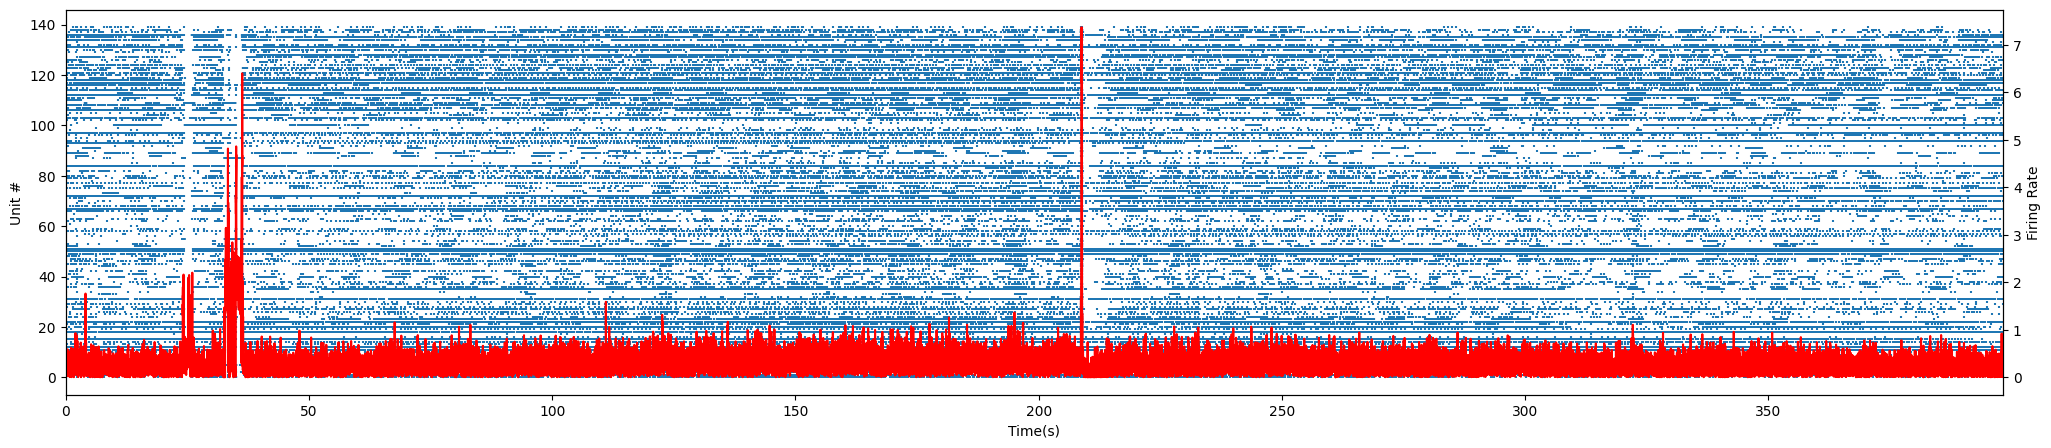

In [7]:
raster_fancy_plot(sd, xsize=25, ysize=5)

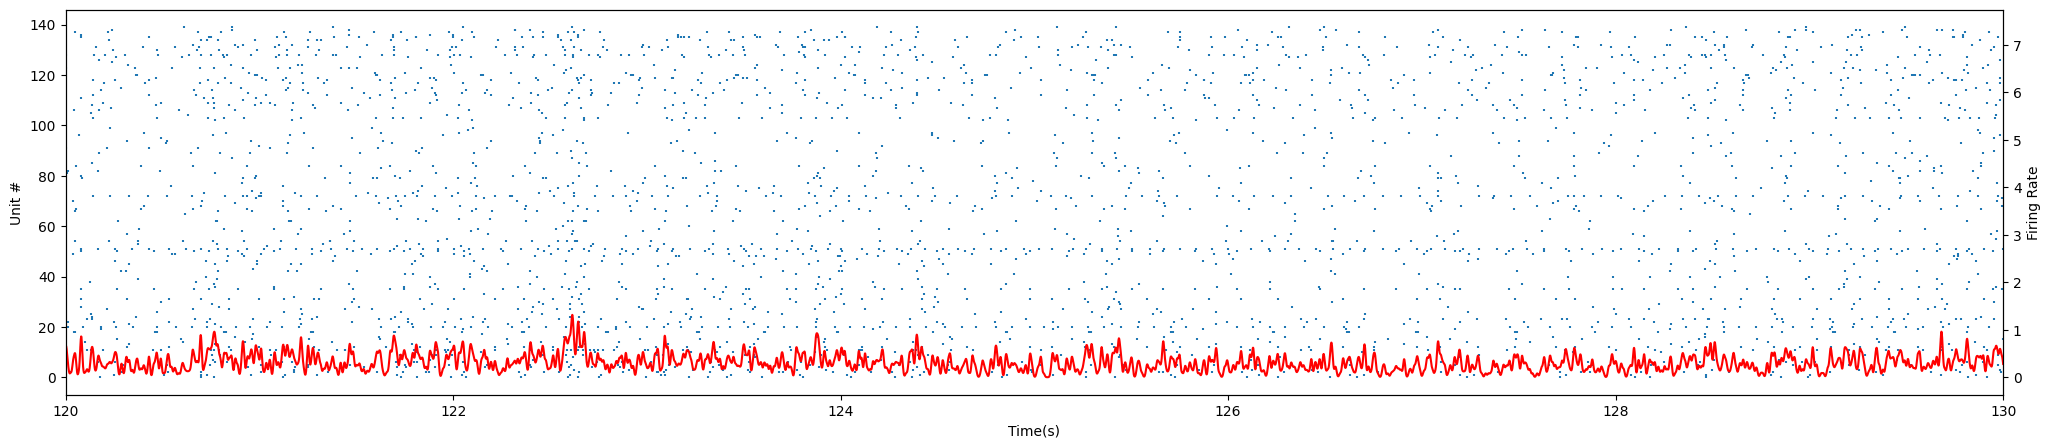

In [10]:
raster_fancy_plot(sd, xsize=25, ysize=5, start_time=120, stop_time=130)

## Download Data Locally

We now need to download the raw data from the braingeneers cloud storage, the NRP. To do this you will need the braingeneers credentials file. If you don't have one, reach out to David Parks about this. Once you have a credentials file, upload it into this codespace. Whenever you create a new codespace, you will have to upload the credentials file. Put the credentials file in the following folder locaction in order to run the commands that follow.

`/home/jovyan/.aws/credentials`

You will now need to locate the raw data you want to download on the NRP. Use `ls` command to sift through folder until you find the file/folder you want to download. Note, these commands shoudl be run inside the codespace's terminal, not a notebook.

```
aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 ls s3://braingeneers/ephys/2023-04-02-e-hc328_unperturbed/
```

You can download the data into the codesapce using the `cp` command below. Download the data into hte folder `/workspaces/human_hippocampus/data/ephys` . This ensures that whatever you download won't be saved to Github. The reason we don't save these to Github repository is because the files are massive.

 In order to properly access the files you will need to follow the same folder format as seen on the NRP. You will also need to make sure you download the `metadata.json` file for the turorial to work. Note, while this comands works in this example, in general there may be a LOT GB's of raw data, so insteado of download the entire folder from the NRP, you may have to download the specific files you need.

```
aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 cp s3://braingeneers/ephys/2023-04-02-e-hc328_unperturbed /workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/ --recursive
```

In [ ]:
### Example comands for downloading indiviual files
#mkdir -p "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/original/data/"
#aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 cp "s3://braingeneers/ephys/2022-10-20-e-/original/data/hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5" "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/original/data/hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5" 
#mkdir -p "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/derived"
#aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 cp "s3://braingeneers/ephys/2022-10-20-e-/derived" "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/derived" --recursive 
#aws --endpoint https://s3.braingeneers.gi.ucsc.edu s3 cp "s3://braingeneers/ephys/2022-10-20-e-/metadata.json" "/workspaces/human_hippocampus/data/ephys/2022-10-20-e-/" 

## Load Data into Python

Now that you are running a larger than usual codespace, and you have downloaded the data locally, you can load the data into python. 

import stuff

In [4]:
import braingeneers
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys

load metadata

In [11]:
braingeneers.set_default_endpoint("/workspaces/human_hippocampus/data")
metadata = ephys.load_metadata("2023-04-02-e-hc328_unperturbed")

load data into python

<font color="orange">

**Note** the `load_data` function actually has 2 parameters I haven't yet played with, `length` and `offset`. I believe these can be used to select a subset of the data to load into python. I haven't tested this, but I believe if you use these commands you may be able to load and process the data in python without creating a massive codespace with 64gb of RAM.

In [13]:
raw_data = ephys.load_data( metadata=metadata, experiment="experiment1", offset=120*20000, length=10*20000, channels=None )

/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/data/datasets_electrophysiology.py:197: UserWarning: Dataset 2023-04-02-e-hc328_unperturbed is not in row-major format, the parallel data reader can't be used, read speeds may be slow over a network.
  warnings.warn(f'Dataset {batch_uuid} is not in row-major format, the parallel data reader '


/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/data/datasets_electrophysiology.py:209: UserWarning: Metadata is missing the required voltage_scaling_factor attribute. Using default value of 1.0.
  warnings.warn('Metadata is missing the required voltage_scaling_factor attribute. Using default value of 1.0.')


In [14]:
# check data shape is correct #len(raw_data) #check the recording is about the right length len(raw_data[0])/20000
raw_data.shape

(1028, 200000)

## Downsample data

Now that we have loaded the data into python we have select a subset of time from the data for which we want to analyze. For our analysis we don't actually need to consider every 20000 datapoints per second. For this reason, we `downsample` this subset of the data, which means that we consider, say, every other datapoint. This cuts the size of the data in half. In actuallity we on take every 40th datapoint.

In [15]:
from scipy import signal

function to downsample data

In [16]:
# Downsample abd remove artifact
def downsample(wav_lfp, dec=20, fs=20000.0):
    wav_data = signal.decimate(wav_lfp, dec)
    return fs/dec, wav_data

In [17]:
decimate = 20
fs= 20000
down_fs = fs/decimate

In [20]:
data_down = []  # the variable that will hold the downsambled data
for i in range(len(raw_data)-4): # we run this loop for all code except the last 4 channels, because they are dummy data
    data_down.append( downsample( raw_data[i, 0:(fs*20)], dec=decimate, fs=fs)[1]  ) # we select the first 20seconds of the data, and then downsample it
data_down = np.array( data_down ) # we turn the data into an np.array for easier future analysis

# Channel Electrode Mapping

In [22]:
import numpy as np
from matplotlib import pyplot as plt

In [24]:
channel_map = metadata['ephys_experiments']['experiment1']["mapping"]
channel_map = np.array(channel_map)
channel_map.shape

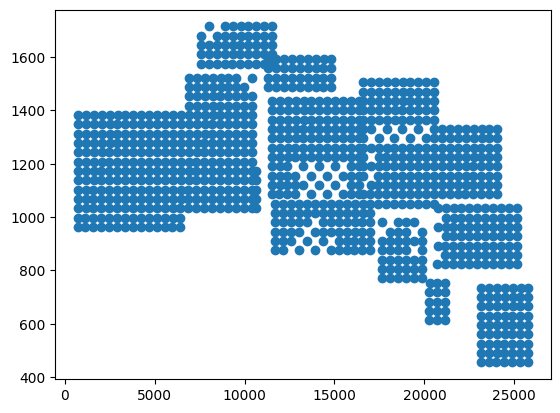

In [31]:
# make a scatterplot of the first and seconds columns of channel_map
plt.scatter(channel_map[:,1], channel_map[:,2] )

In [34]:
processed_data = data_down[ channel_map[:,0].astype(int), : ]

In [32]:
channel_xy= channel_map[:,1:3]

# Save Data

Save the dataset. We save the data in the folder `ephys_raw` instead of ephys so that the data is available on Github.

<font color="orange">This line is commented out to make sure we don't accidently overwrite the previous saved data

In [36]:
import pickle

In [38]:
to_pickle = {"data": processed_data, "xy": channel_xy, "frame_rate": down_fs}

In [39]:
# with open( '/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/raw_start120s_stop130s_fs1ms.pkl' , 'wb') as file:
#     pickle.dump(to_pickle, file)

check that we can load the data correctly

In [41]:
file = open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/raw_start120s_stop130s_fs1ms.pkl', 'rb')
checkit = pickle.load(file)
file.close()
checkit

{'data': array([[392.7012 , 395.25186, 395.22208, ..., 397.01382, 400.0254 ,
         402.39658],
        [519.29395, 521.4816 , 521.74756, ..., 526.737  , 524.22644,
         522.1528 ],
        [181.98549, 185.0614 , 183.18318, ..., 186.21301, 182.86412,
         182.11726],
        ...,
        [523.55554, 527.2294 , 528.5211 , ..., 525.5148 , 525.2215 ,
         525.5384 ],
        [355.98215, 358.15442, 358.1233 , ..., 340.62662, 340.09097,
         340.0443 ],
        [471.07196, 474.3375 , 474.87775, ..., 468.7652 , 469.24545,
         469.9821 ]], dtype=float32),
 'xy': array([[18964.,   770.],
        [13714.,  1295.],
        [12160.,  1050.],
        ...,
        [ 8898.,  1715.],
        [23142.,   735.],
        [20540.,  1400.]]),
 'frame_rate': 1000.0}

##  <font color="red"> Filter Data - Never Done

<font color="red"> I never actually implemented this code. I figure is better to do things like filtering after the data is saved, just in case we do it wrong. Check out the next tutorial to see filtering.

helper function for filtering data

```
def butter_filter(data, lowcut=None, highcut=None, fs=20000.0, order=5):
    """
    A digital butterworth filter. Type is based on input value.
    Inputs:
        data: array_like data to be filtered
        lowcut: low cutoff frequency. If None or 0, highcut must be a number.
                Filter is lowpass.
        highcut: high cutoff frequency. If None, lowpass must be a non-zero number.
                 Filter is highpass.
        If lowcut and highcut are both give, this filter is bandpass.
        In this case, lowcut must be smaller than highcut.
        fs: sample rate
        order: order of the filter
    Return:
        The filtered output with the same shape as data
    """

    assert (lowcut not in [None, 0]) or (highcut != None), \
        "Need at least a low cutoff (lowcut) or high cutoff (highcut) frequency!"
    if (lowcut != None) and (highcut != None):
        assert lowcut < highcut, "lowcut must be smaller than highcut"

    if lowcut == None or lowcut == 0:
        filter_type = 'lowpass'
        Wn = highcut / fs * 2
    elif highcut == None:
        filter_type = 'highpass'
        Wn = lowcut / fs * 2
    else:
        filter_type = "bandpass"
        band = [lowcut, highcut]
        Wn = [e / fs * 2 for e in band]

    filter_coeff = signal.iirfilter(order, Wn, analog=False, btype=filter_type, output='sos')
    filtered_traces = signal.sosfiltfilt(filter_coeff, data)
    return filtered_traces
```

run filter on data

In [9]:
#low_cut, high_cut = 0.1, 100
#data_ds = butter_filter(raw_data, low_cut, high_cut)
